# Cold Face Test – Heart Rate Plots

In [1]:
import json
import re
from pathlib import Path

import pandas as pd
import numpy as np
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

from fau_colors import cmaps, colors_all
import biopsykit as bp
from biopsykit.protocols import MIST
from biopsykit.utils.dataframe_handling import multi_xs

from cft_analysis.datasets import CftDatasetProcessed

from IPython.display import Markdown

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
plt.close("all")

palette = sns.color_palette(cmaps.faculties)
sns.set_theme(context="notebook", style="ticks", palette=palette)

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"

palette

[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.4666666666666667, 0.6235294117647059, 0.7098039215686275),
 (1.0, 0.7215686274509804, 0.10980392156862745),
 (0.0, 0.6392156862745098, 0.8784313725490196),
 (0.2627450980392157, 0.6901960784313725, 0.16470588235294117),
 (0.7843137254901961, 0.06274509803921569, 0.1803921568627451)]

## Data Import

In [3]:
# get path to analysis results
base_path = Path("../../data")

In [4]:
results_path = base_path.joinpath("../results")
stats_path = results_path.joinpath("statistics")
plot_path = results_path.joinpath("plots")
bp.utils.file_handling.mkdirs([results_path, stats_path, plot_path])

paper_path = Path("../paper_path.json")
paper_img_path = None
if paper_path.exists():
    paper_path = Path(json.load(paper_path.open(encoding="utf-8"))["paper_path"])
    paper_img_path = paper_path.joinpath("img")
    bp.utils.file_handling.mkdirs([paper_img_path])

In [5]:
hue_order = ["Control", "CFT"]

In [6]:
dataset = CftDatasetProcessed(base_path, exclude_subjects=True)
dataset

,condition,subject,phase,subphase
0,CFT,Vp01,MIST1,AT
1,CFT,Vp01,MIST1,AT
2,CFT,Vp01,MIST1,AT
3,CFT,Vp01,MIST1,AT
4,CFT,Vp01,MIST1,AT
...,...,...,...,...
4443,Control,Vp33,Post,Total
4444,Control,Vp33,Pre,Total
4445,Control,Vp33,Pre,Total
4446,Control,Vp33,Pre,Total


In [7]:
hr_ensemble = dataset.heart_rate_ensemble
hr_mean = dataset.heart_rate
hr_mean = hr_mean.xs("HR_Norm", level="type")
hr_mean.head()

data
condition subject phase subphase category           
CFT       Vp01    MIST1 AT       HR        -4.866102
                        BL       HR        -4.845864
                        FB       HR        -5.795996
                        RP_CFI   HR       -12.341485
                  MIST2 AT       HR        -7.483283

In [8]:
mist = MIST.from_file(base_path.joinpath("mist_cft.json"))
mist

CFT
        Structure: {'Pre': None, 'MIST': {'MIST1': {'BL': 60, 'RP_CFI': 120, 'AT': 240, 'FB': 0}, 'MIST2': {'BL': 60, 'RP_CFI': 120, 'AT': 240, 'FB': 0}, 'MIST3': {'BL': 60, 'RP_CFI': 120, 'AT': 240, 'FB': 0}}, 'Post': None}

In [9]:
mist.add_hr_ensemble("hr_ensemble", {key: val.xs(key) for key, val in hr_ensemble.groupby("phase")})

hr_mean = hr_mean.rename({"RP_CFI": "RP/CFI"}, level="subphase")
mist.add_hr_results("hr_mean", hr_mean)

## HR Ensemble Plot

[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.37254901960784315, 0.48819684736639757, 0.6382929642445214),
 (0.6235294117647059, 0.6929181084198386, 0.7829757785467129),
 (0.7490196078431373, 0.795278738946559, 0.8553171856978086),
 (0.8745098039215686, 0.8976393694732795, 0.9276585928489043)]

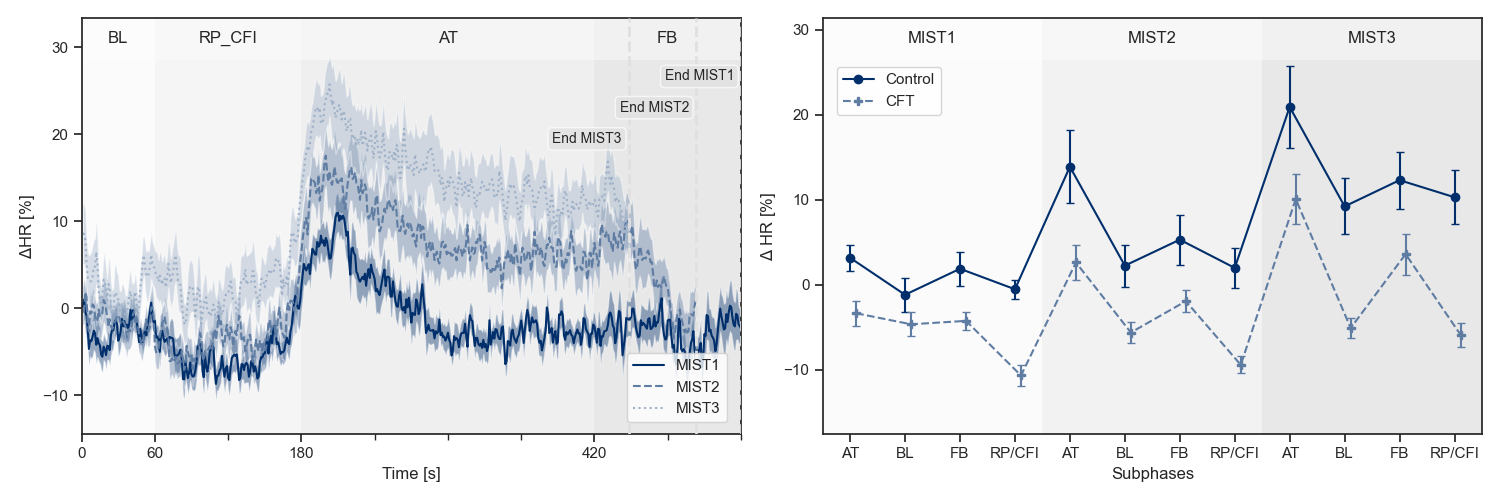

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))


# HR Ensemble Plot
mist.hr_ensemble_plot("hr_ensemble", ax=axs[0], palette=sns.color_palette(cmaps.fau))

# HR Mean Plot
mist.hr_mean_plot("hr_mean", is_relative=True, ax=axs[1], order=hue_order, palette=sns.color_palette(cmaps.fau))

for path in [plot_path, paper_img_path]:
    if path is not None:
        fig.savefig(path.joinpath("img_hr_mean_ensemble.pdf"), transparent=True)

## HR Feature Plot

In [ ]:
display(Markdown("### Prepare Data"))

phases = ["MIST1", "MIST2", "MIST3"]
subphases = ["BL", "RP_CFI"]
hr_measures = ["HR_Norm", "HRV_RMSSD", "HRV_pNN50"]
time_bl_measures = ["HR", "HRV_RMSSD", "HRV_pNN50"]

hr_analysis = dataset.get_subset(phase=phases, subphase=subphases).hr_hrv
hr_analysis = multi_xs(hr_analysis, hr_measures, level="type")
time_bl_analysis = dataset.get_subset(phase=phases, subphase=subphases).time_above_baseline
time_bl_analysis = multi_xs(time_bl_analysis, time_bl_measures, level="type")

hr_analysis = hr_analysis.unstack(["type", "category"]).join(time_bl_analysis.unstack(["type", "category"]))
hr_analysis = hr_analysis.stack(["category", "type"])
display(hr_analysis.head())


#################################################################
display(Markdown("### Statistics"))

steps = [("prep", "normality"), ("prep", "equal_var"), ("test", "mixed_anova"), ("posthoc", "pairwise_ttests")]
params = {
    "dv": "data",
    "within": "phase",
    "between": "condition",
    "subject": "subject",
    "groupby": ["category", "type", "subphase"],
    "padjust": "bonf",
}

stats = bp.stats.StatsPipeline(steps, params)
stats.apply(hr_analysis)

stats.display_results(prep=False, posthoc=False, sig_only=["test", "posthoc"])

### Boxplots

In [ ]:
fig, axs = plt.subplots(ncols=2)

category = ["HR"]
feature = ["HR_Norm"]
subphase = ["BL"]

hr_plot = dataset.get_subset(subphase=subphase).heart_rate
hr_plot = multi_xs(hr_plot, feature, level="type")

stats_data = stats.results_cat("posthoc").loc[category, feature, subphase]
box_pairs, pvalues = stats.sig_brackets(stats_data, stats_effect_type="interaction", plot_type="multi", x="phase")


bp.plotting.feature_boxplot(
    data=hr_plot.reset_index(),
    x="phase",
    y="data",
    hue="condition",
    hue_order=hue_order,
    stats_kwargs={"box_pairs": box_pairs, "pvalues": pvalues},
    legend_loc="upper left",
    ax=axs[0],
)
axs[0].set_xlabel("Phase")
axs[0].set_ylabel("$\Delta HR$ during $BL$ [%]")

category = ["Time_BL_Glo"]
feature = ["HR"]
subphase = ["BL"]

hr_plot = dataset.get_subset(subphase=subphase).time_above_baseline
hr_plot = multi_xs(hr_plot, feature, level="type")


stats_data = stats.results_cat("posthoc").loc[category, feature, subphase, :]
box_pairs, pvalues = stats.sig_brackets(stats_data, stats_effect_type="interaction", plot_type="multi", x="phase")

bp.plotting.feature_boxplot(
    data=hr_plot.reset_index(),
    x="phase",
    y="data",
    hue="condition",
    hue_order=hue_order,
    stats_kwargs={"box_pairs": box_pairs, "pvalues": pvalues},
    legend_loc="upper left",
    ax=axs[1],
)


axs[1].set_xlabel("Phase")
axs[1].set_ylabel("$\hat{t}_{Glo}(HR)$ during $BL$ [%]")

for path in [paper_path, paper_img_path]:
    if path is not None:
        fig.savefig(path.joinpath("img_boxplot_hr_features.pdf"), transparent=True)
fig.tight_layout()